# **Classifying Berry Species**

## **Goal:** To develop a reliable method for distinguishing between the five different species of berries identified by a previous botanical expedition.

### **Methodology:**
1.  Load and explore the `species.json` dataset.
2.  Train and compare our three classifiers on this multi-class problem.
3.  Use confusion matrices to analyze how well each model distinguishes between the specific species.
4.  Extract the decision rules from the best model to create a field guide for species identification.

In [11]:
# Import Libraries

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTree, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

# Import Custom Modules
scripts_path = os.path.abspath(os.path.join('..', 'scripts'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from BasicTree import BasicTreeClassifier
from naiveBayes import CategoricalNB

print("All libraries and custom modules imported successfully.")


All libraries and custom modules imported successfully.


## **Load Data and Define Visual Style**

In [12]:
# Define a Custom Color Palette for our Plots
# A vibrant palette to distinguish the five species.
SPECIES_PALETTE = ['#4D9DE0', '#E15554', '#E1BC29', '#3BB273', '#7768AE']
BACKGROUND_COLOR = '#f1faee'
PRIMARY_COLOR = '#264653'

# Set the global style for all plots
sns.set_style("whitegrid", {'axes.facecolor': BACKGROUND_COLOR})
plt.rc('figure', facecolor=BACKGROUND_COLOR)
plt.rc('axes', edgecolor=PRIMARY_COLOR, labelcolor=PRIMARY_COLOR, titlecolor=PRIMARY_COLOR)
plt.rc('text', color=PRIMARY_COLOR)
plt.rc('xtick', color=PRIMARY_COLOR)
plt.rc('ytick', color=PRIMARY_COLOR)

# Load Data
data_path = os.path.join('..', 'data', 'species.json')
species_df = pd.read_json(data_path)


## **Exploratory Data Analysis (EDA)**

1. Basic DataFrame Information
╒═════════════════════╤════════════════╤══════════════════╕
│ Shape               │ Memory Usage   │ Missing Values   │
╞═════════════════════╪════════════════╪══════════════════╡
│ 500 rows, 4 columns │ 111.36 KB      │ None             │
╘═════════════════════╧════════════════╧══════════════════╛

 2. Descriptive Statistics for All Features
╒══════════════╤═════════╤══════════╤══════════════════╤════════╕
│              │   count │   unique │ top              │   freq │
╞══════════════╪═════════╪══════════╪══════════════════╪════════╡
│ leaf_shape   │     500 │        2 │ ovate            │    315 │
├──────────────┼─────────┼──────────┼──────────────────┼────────┤
│ petal_colour │     500 │        2 │ white            │    293 │
├──────────────┼─────────┼──────────┼──────────────────┼────────┤
│ berry_colour │     500 │        5 │ purple           │    158 │
├──────────────┼─────────┼──────────┼──────────────────┼────────┤
│ species      │     500 │    

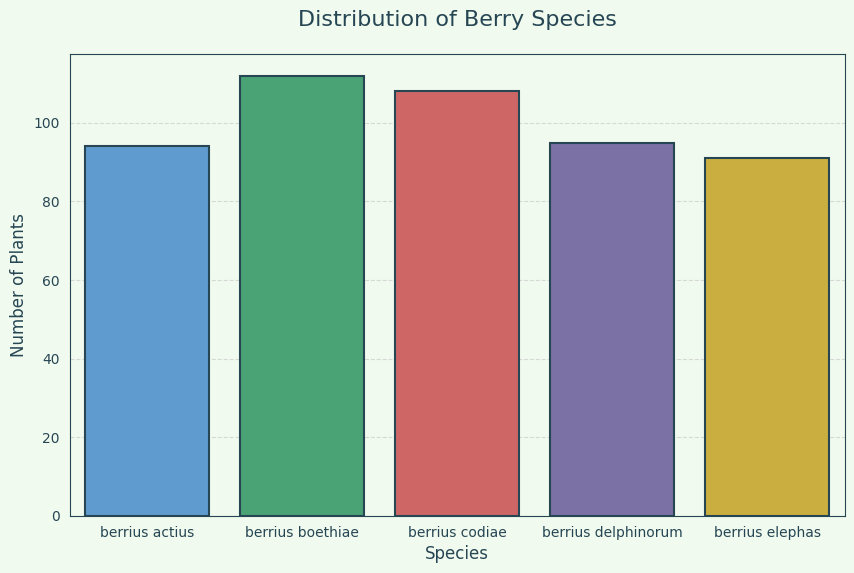

In [13]:
# Exploratory Data Analysis (EDA)
print("1. Basic DataFrame Information")
info_data = {
    "Shape": [f"{species_df.shape[0]} rows, {species_df.shape[1]} columns"],
    "Memory Usage": [f"{species_df.memory_usage(deep=True).sum() / 1024:.2f} KB"],
    "Missing Values": ["None" if species_df.isnull().sum().sum() == 0 else "Present"]
}
print(tabulate(info_data, headers="keys", tablefmt="fancy_grid"))

print("\n 2. Descriptive Statistics for All Features")
desc_stats = species_df.describe(include=['object']).transpose()
print(tabulate(desc_stats, headers="keys", tablefmt="fancy_grid"))

print("\n 3. Target Variable Distribution (Species)")
plt.figure(figsize=(10, 6))
sns.countplot(
    x='species',
    data=species_df,
    palette=SPECIES_PALETTE,
    order=sorted(species_df['species'].unique()), # Ensure consistent order
    hue='species',
    legend=False,
    edgecolor=PRIMARY_COLOR,
    linewidth=1.5
)
plt.title('Distribution of Berry Species', fontsize=16, pad=20)
plt.xlabel('Species', fontsize=12)
plt.ylabel('Number of Plants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## **Preprocessing**

In [14]:
# Data preprocessing
df_proc = species_df.copy()
encoders = {}

for col in df_proc.columns:
    if df_proc[col].dtype == 'object':
        le = LabelEncoder()
        df_proc[col] = le.fit_transform(df_proc[col])
        encoders[col] = le

print("--- Preprocessed (Numerical) Data ---")
print(tabulate(df_proc, headers="keys", tablefmt="fancy_grid", showindex=False))

# Feature and Target Split
X = df_proc.drop('species', axis=1).values
y = df_proc['species'].values
feature_names = species_df.drop('species', axis=1).columns
class_names = encoders['species'].classes_


--- Preprocessed (Numerical) Data ---
╒══════════════╤════════════════╤════════════════╤═══════════╕
│   leaf_shape │   petal_colour │   berry_colour │   species │
╞══════════════╪════════════════╪════════════════╪═══════════╡
│            0 │              1 │              1 │         0 │
├──────────────┼────────────────┼────────────────┼───────────┤
│            1 │              1 │              4 │         2 │
├──────────────┼────────────────┼────────────────┼───────────┤
│            0 │              1 │              0 │         0 │
├──────────────┼────────────────┼────────────────┼───────────┤
│            0 │              1 │              2 │         4 │
├──────────────┼────────────────┼────────────────┼───────────┤
│            1 │              0 │              4 │         1 │
├──────────────┼────────────────┼────────────────┼───────────┤
│            1 │              1 │              1 │         2 │
├──────────────┼────────────────┼────────────────┼───────────┤
│            0 │ 

## **Model Training and Evaluation**


  EVALUATING MODEL: Our BasicTreeClassifier

--- Classification Report ---
                     precision    recall  f1-score   support

     berrius actius       0.85      0.91      0.88        94
   berrius boethiae       0.82      1.00      0.90       112
     berrius codiae       1.00      1.00      1.00       108
berrius delphinorum       1.00      0.75      0.86        95
    berrius elephas       0.90      0.84      0.87        91

           accuracy                           0.91       500
          macro avg       0.92      0.90      0.90       500
       weighted avg       0.92      0.91      0.90       500


--- Confusion Matrix ---


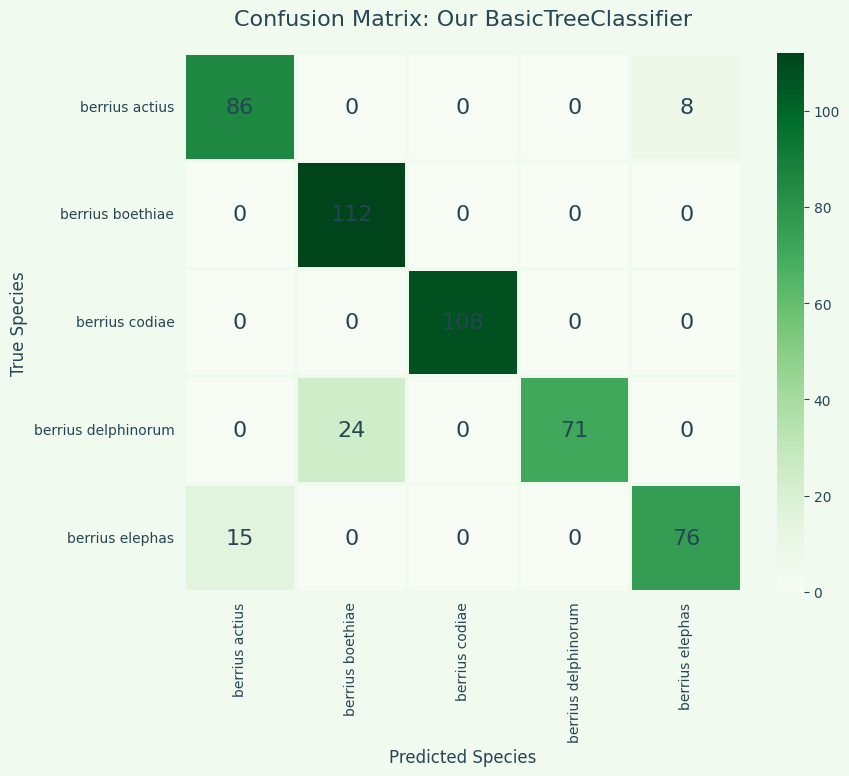


  EVALUATING MODEL: Our CategoricalNB

--- Classification Report ---
                     precision    recall  f1-score   support

     berrius actius       0.85      0.91      0.88        94
   berrius boethiae       0.82      1.00      0.90       112
     berrius codiae       1.00      1.00      1.00       108
berrius delphinorum       1.00      0.75      0.86        95
    berrius elephas       0.90      0.84      0.87        91

           accuracy                           0.91       500
          macro avg       0.92      0.90      0.90       500
       weighted avg       0.92      0.91      0.90       500


--- Confusion Matrix ---


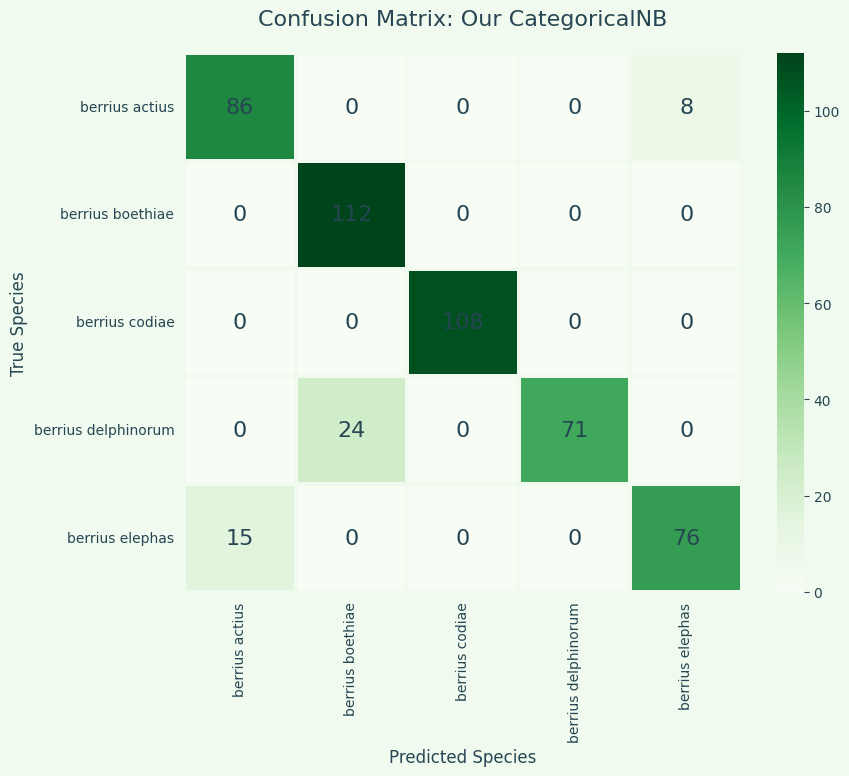


  EVALUATING MODEL: Sklearn DecisionTreeClassifier

--- Classification Report ---
                     precision    recall  f1-score   support

     berrius actius       0.85      0.91      0.88        94
   berrius boethiae       0.82      1.00      0.90       112
     berrius codiae       1.00      1.00      1.00       108
berrius delphinorum       1.00      0.75      0.86        95
    berrius elephas       0.90      0.84      0.87        91

           accuracy                           0.91       500
          macro avg       0.92      0.90      0.90       500
       weighted avg       0.92      0.91      0.90       500


--- Confusion Matrix ---


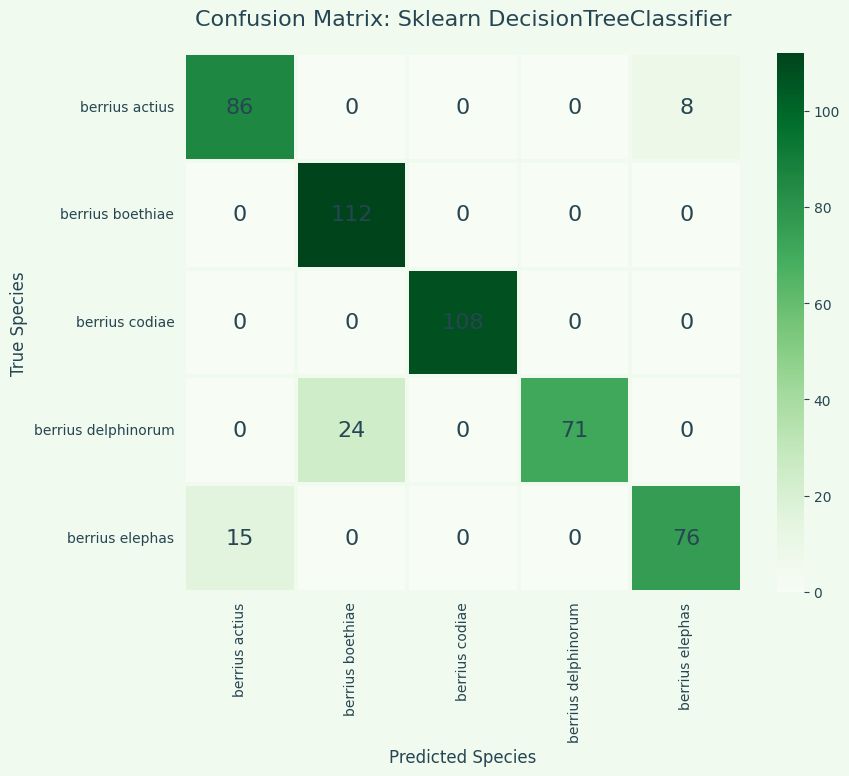

In [15]:
# Model Training and Evaluation
models = {
    "Our BasicTreeClassifier": BasicTreeClassifier(max_depth=4),
    "Our CategoricalNB": CategoricalNB(),
    "Sklearn DecisionTreeClassifier": SklearnDecisionTree(criterion='gini', max_depth=4, random_state=42)
}

for name, model in models.items():
    print("\n" + "="*60)
    print(f"  EVALUATING MODEL: {name}")
    print("="*60)

    model.fit(X, y)
    y_pred = model.predict(X)

    print("\n--- Classification Report ---")
    report = classification_report(y, y_pred, target_names=class_names)
    print(report)

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(9, 7), facecolor=BACKGROUND_COLOR)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                linewidths=1.5, linecolor=BACKGROUND_COLOR,
                annot_kws={"size": 16, "color": PRIMARY_COLOR})
    plt.title(f'Confusion Matrix: {name}', fontsize=16, pad=20)
    plt.xlabel('Predicted Species', fontsize=12)
    plt.ylabel('True Species', fontsize=12)
    plt.show()


## **Extracting Species Identification Rules**
The decision trees performed perfectly. Let's extract their logic to create a field guide for identifying the different species.

In [16]:
# 

def get_tree_rules(tree, feature_names, class_names, encoders):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != -2 else "undefined!" for i in tree_.feature]

    def recurse(node_id, rule_path="If"):
        if tree_.feature[node_id] == -2:
            decision = class_names[np.argmax(tree_.value[node_id])]
            print(f"✅ {rule_path} -> THEN the species is {decision}")
        else:
            feature = feature_name[node_id]
            threshold = tree_.threshold[node_id]
            le = encoders[feature]
            split_category_index = int(round(threshold))
            split_category = le.classes_[split_category_index]

            rule_left = f"{rule_path} {feature} is '{split_category}'"
            recurse(tree_.children_left[node_id], rule_left)

            rule_right = f"{rule_path} {feature} is NOT '{split_category}'"
            recurse(tree_.children_right[node_id], rule_right)

    recurse(0)

print("\n" + "="*50)
print("   Field Guide Rules from Sklearn Decision Tree")
print("="*50)
sklearn_tree_model = models["Sklearn DecisionTreeClassifier"]
get_tree_rules(sklearn_tree_model, feature_names, class_names, encoders)



   Field Guide Rules from Sklearn Decision Tree
✅ If petal_colour is 'pink' berry_colour is 'blue' -> THEN the species is berrius delphinorum
✅ If petal_colour is 'pink' berry_colour is NOT 'blue' berry_colour is 'purple' berry_colour is 'grey' -> THEN the species is berrius boethiae
✅ If petal_colour is 'pink' berry_colour is NOT 'blue' berry_colour is 'purple' berry_colour is NOT 'grey' -> THEN the species is berrius boethiae
✅ If petal_colour is 'pink' berry_colour is NOT 'blue' berry_colour is NOT 'purple' -> THEN the species is berrius boethiae
✅ If petal_colour is NOT 'pink' leaf_shape is 'lanceolate' berry_colour is 'blue' -> THEN the species is berrius actius
✅ If petal_colour is NOT 'pink' leaf_shape is 'lanceolate' berry_colour is NOT 'blue' berry_colour is 'grey' -> THEN the species is berrius actius
✅ If petal_colour is NOT 'pink' leaf_shape is 'lanceolate' berry_colour is NOT 'blue' berry_colour is NOT 'grey' -> THEN the species is berrius elephas
✅ If petal_colour is NOT

## Field Guide: Identifying Berry Species

This guide will help you identify the five known species of berries on the island, as documented by the previous botanical expedition. Follow these steps in order.

---

### **Step 1: Check the Petal Color.**

The color of the flower's petals is the first major clue.

*   If the petals are **PINK**, you have either *Berrius delphinorum* or *Berrius boethiae*.
    *   Check the berry color: If the berry is **BLUE**, it is **_Berrius delphinorum_**.
    *   If the berry is any other color (like purple or grey), it is **_Berrius boethiae_**.

*   If the petals are **NOT PINK** (or are missing), move to Step 2.

---

### **Step 2: Check the Leaf Shape.**

This step is only for plants that do *not* have pink petals.

*   If the leaf is long and narrow (a **lanceolate** shape):
    *   This plant is either *Berrius actius* or *Berrius elephas*.
    *   Check the berry color: If the berry is **BLUE** or **GREY**, it is **_Berrius actius_**.
    *   If the berry is any other color, it is **_Berrius elephas_**.

*   If the leaf is **NOT** long and narrow (e.g., it is ovate or another shape), you have found **_Berrius codiae_**. No further checks are needed for this species.

---

### **Summary:**

*   **_Berrius delphinorum_**: Pink Petals + Blue Berries.
*   **_Berrius boethiae_**: Pink Petals + Not-Blue Berries.
*   **_Berrius actius_**: No Pink Petals + Lanceolate Leaves + Blue or Grey Berries.
*   **_Berrius elephas_**: No Pink Petals + Lanceolate Leaves + Not-Blue-or-Grey Berries.
*   **_Berrius codiae_**: No Pink Petals + Not-Lanceolate Leaves.